### Semantic kernel Vector Search with chat context/history 

In session 3, we walked through a simple example based on a fictitious company called Contoso, Ltd. In that example, an employee wanted to simply connect to company's database to retrieve some simple information or add a new record.

Now let's consider a different scenario. 

Let's assume the company has a chatbot that provides below basic support to customers:
1. Provides state of shipment
2. Provides state of return
2. Gives information about available products
3. Recommends best product based on customer needs and inventory

For an optimal experience, the chatbot needs to not only access product inventory, sales, shipment and return data, but also it would need to be able to pick up the conversation with each customer where it was left off, if required.

For this usecase, we are going to introduce and use below semantic kernel capabilities (in addition to what we covered before) to develop a solution:
- Chat completion **Agent** to manage the conversation thread and data access (one agent)
- Store and maintain **chat history** per customer and session, and retrieve the history for a customer/session when needed.
  -- We will persist the history in **CosmosDB**
- Vector search using Semantic Kernel Vector Store connectors
  -- Use company data as context to guide the conversation aka **RAG**



### Expanding the plugin

In previous session, we defined a class that enabled some basic functionalities to interact with the database. Now let's think about what data would the chatbot need to access and create a plugin to pull in that data:
- For this example we design the Chatbot so that it requires the customer to provide a unique identifier, and also a tracking number if they are following up on a previous conversation. 

Chatbot will need to access the following data to be able to assist the customer:
    - All sales data for the customer
    - All Return data for the customer
    - All basic customer info
    - All reviews and ratings provided by that customer
    - Data about all product offerings.

Below we will expand the plugin class to accomodate above requirements:


In [1]:
import psycopg2
from pandas import DataFrame
from typing import Optional
from semantic_kernel.functions import kernel_function


class Contoso_ChatPlugin:
    def __init__(self, db_uri: str):
        self.conn = psycopg2.connect(db_uri)
        self.cursor = self.conn.cursor()
        print("Connected to company's database successfully.")
    
    @kernel_function
    async def get_all_products(self) -> list[dict]:
        """Gets all products info from the database."""
        query = """SELECT * FROM products;"""
        self.cursor.execute(query)
        rows = self.cursor.fetchall()
        columns = [desc[0] for desc in self.cursor.description]
        try:
            products = DataFrame(rows, columns=columns)
            return products.to_dict(orient="records")  # <-- JSON serializable
        except Exception as e:
            print(f"Error fetching products: {e}")
            return None

    @kernel_function
    async def get_product_info(self, product_name: Optional[str] = None, product_id: Optional[int] = None) -> list[dict]:
        """Retrieves product information based on product name or ID."""
        query = """SELECT 
                    product_id,                   
                    name,
                    inventory,
                    price,
                    refurbished,
                    category
                FROM products
                WHERE (LOWER(name) = LOWER(%(product_name)s) AND %(product_name)s IS NOT NULL)
                   OR (product_id = %(product_id)s AND %(product_id)s IS NOT NULL)
                   """
        if not product_name and not product_id:
            print("No valid product name or ID provided.")
            return None
        elif product_id:
            self.cursor.execute(query, {"product_name": None, "product_id": product_id})
        else:
            self.cursor.execute(query, {"product_name": product_name, "product_id": None})

            
        rows = self.cursor.fetchall()
        columns = [desc[0] for desc in self.cursor.description]
        try:
            products= DataFrame(rows, columns=columns)
            products.to_dict(orient="records")  # <-- JSON serializabl
            
            return products.to_dict(orient="records")  # <-- JSON serializabl
        except Exception as e:
            print(f"Error fetching product information: {e}")
            return None
    @kernel_function
    async def get_customer_info(self, given_customer_id: int) -> list[dict]:
        """Gets all customer product information from the database."""
        query = """SELECT
                        customer_id,
                        city,
                        state,
                        country,
                        sentiment_score,
                        name,
                        email 
                    
                    FROM customers
                WHERE customer_id = %(given_customer_id)s;
                   """
        self.cursor.execute(query, {"given_customer_id": given_customer_id})
        row = self.cursor.fetchone()
        if row:
            columns = [desc[0] for desc in self.cursor.description]
            return dict(zip(columns, row))
        else:
            print(f"No record was found for this customer")
            return None
        
    @kernel_function
    def get_customer_sales_info(self, given_customer_id: int) -> Optional[dict]:
        """Returns all sales info for a customer"""
        query = """
            SELECT sales.sales_id, sales.customer_id, sales.quantity,
                sales.product_id, sales.sale_date, products.name, products.price
            FROM sales
            JOIN products ON sales.product_id = products.product_id
            JOIN customers ON sales.customer_id = customers.customer_id
            WHERE customers.customer_id = %(given_customer_id)s;
        """
        self.cursor.execute(query, {"given_customer_id": given_customer_id})
        row = self.cursor.fetchone()
        if row:
            columns = [desc[0] for desc in self.cursor.description]
            return dict(zip(columns, row))
        else:
            print(f"No sales data found for this customer")
            return None
        
    @kernel_function
    def get_customer_returns_info(self, given_customer_id: int) -> Optional[dict]:
        """Returns all returns info for a customer"""
        query = """SELECT 
                        return_items.return_id,
                        return_items.sales_id,
                        return_items.return_status,
                        return_items.reason,
                        return_items.status_date,
                        sales.customer_id,
                        sales.product_id,
                        sales.sale_date
                    FROM 
                        return_items
                    JOIN 
                        sales ON return_items.sales_id = sales.sales_id
                    JOIN
                        customers ON sales.customer_id = customers.customer_id
                    WHERE 
                        customers.customer_id = %(given_customer_id)s;

        """
        self.cursor.execute(query, {"given_customer_id": given_customer_id})
        row = self.cursor.fetchone()
        if row:
            columns = [desc[0] for desc in self.cursor.description]
            return dict(zip(columns, row))
        else:
            print(f"No return data found for this customer")
            return None
    @kernel_function
    def get_customer_shipment_info(self, given_customer_id: int) -> Optional[dict]:
        """Returns all shipment info for a customer"""
        query = """SELECT 
                        shipments.shipment_id,
                        shipments.sales_id,
                        shipments.shipment_date,
                        shipments.shipment_status,
                        sales.customer_id,
                        sales.product_id
                    FROM 
                        shipments
                    JOIN 
                        sales ON shipments.sales_id = sales.sales_id
                    JOIN
                        customers ON sales.customer_id = customers.customer_id
                    WHERE 
                        customers.customer_id = %(given_customer_id)s;
        """
        self.cursor.execute(query, {"given_customer_id": given_customer_id})
        row = self.cursor.fetchone()
        if row:
            columns = [desc[0] for desc in self.cursor.description]
            return dict(zip(columns, row))
        else:
            print(f"No shipment data found for this customer")
            return None

    def close_connection(self):
        """Closes the database connection."""
        self.cursor.close()
        self.conn.close()
        print("Database connection closed.")
    



Now, let's define the agent that will manage the conversation with customers. As before, we need to add the chat completion service, as well as required plugins (to interact with postgreSQL data) to a kernel:

### Defining an example agent

Next, we will initiate a ChatCompletionAgent, and pass the kernel we just created to it to empower it for executing the tasks. We also add some instructions to define its main responsibilties:

In [2]:
from src.get_conn import get_connection_uri
from semantic_kernel.agents import ChatCompletionAgent
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion
from semantic_kernel.kernel import Kernel


conn_uri = get_connection_uri()
chat_kernel = Kernel()
chat_plugin = Contoso_ChatPlugin(db_uri=conn_uri)
chat_kernel.add_plugin(
        plugin = chat_plugin,
        plugin_name = "Chat_Plugin"
    ) 
support_agent = ChatCompletionAgent(
    service=AzureChatCompletion(),
    name="SupportAgent",
    kernel=chat_kernel,
    instructions="You are a support agent for Contoso. You can answer questions about products and customer's sales, and returns. Use the Contoso_ChatPlugin to access the company's database."
)

async def agent_chat(agent, message):
    """Function to handle chat with the agent."""
    res = await agent.get_response(message)
    print(f"Agent response: {res}")




Connection uri was rertieved successfully.
Connected to company's database successfully.


In [3]:
await agent_chat(support_agent, "give me a list of all tvs")

Agent response: Here is a list of all TVs available:

1. Sony TV 55 inch
   - Sony BRAVIA 5 55” Class Mini LED 4K HDR Google TV (2025)
   - Features: Mini LED, 4K HDR, XR Processor with AI, Google TV, HDMI 2.1, Google Assistant
   - Price: $799.99 (new)

2. Sony TV 65 inch
   - Sony BRAVIA XR 65” X90CL
   - Features: Full Array LED, 4K HDR, Cognitive Processor XR, Google TV, Apple AirPlay, Voice Control
   - Price: $999.99 (refurbished)

3. SAMSUNG 75-Inch Crystal UHD DU7100 Series
   - Features: 4K UHD, Crystal Processor 4K, PurColor, Tizen OS, Gaming Hub, Samsung TV Plus, HDR, Smart Connectivity
   - Price: $1599.99 (new)

4. Sony TV OLED
   - Sony BRAVIA XR OLED, QD-OLED panels
   - Features: OLED self-illuminating pixels, XR Processor, Google TV, Dolby Vision, Acoustic Surface Audio+, IMAX Enhanced
   - Price: $1999.99 (new)

5. SAMSUNG TV OLED
   - Samsung S95C OLED TV
   - Features: Quantum Dot OLED, 4K, Neural Quantum Processor, HDR10+, Dolby Atmos, 4K at 144Hz, Gaming features


### Storing and retrieving chat history

As mentioned, chatbot will need to access history of previous converation if needed. Semantic Kernel agents use a class called ChatHistoryAgentThread to store conversation data and keep track of it. So we need to be able to store and retrieve chat history data for each conversation using an isntance of this class.

As mentioned, we choose to store chat history in an Azure Cosmos DB container due to the NoSQL nature of this data. So we need to develop a capability to store the converation history for each customer and chat session to a CosmosDB container.

We have created a database called "Contoso" which has a container called "customer_chats".

First let's connect to the database via the database client, which we can then use to get the container client that we can use to perform read/write operations:

#### connecting to cosmos db

In [4]:
from dotenv import load_dotenv

from azure.cosmos import CosmosClient
import os

load_dotenv()


client = CosmosClient.from_connection_string(os.getenv("COSMOS_CONNECTION_STRING"))

databaseName = os.getenv("COSMOS_DATABASE_NAME")
database = client.get_database_client(databaseName)


containerName =  "customer_chats"
container = database.get_container_client(containerName)

#### Helper functions to store and retrieve chat history via "thread" objects

Next, let's define a class to enbale 1- storing chat history data to the container 2- getting the relevant history data from the container and update the **ChatHistoryAgentThread** object with it:

In [5]:
from semantic_kernel.agents import ChatHistoryAgentThread

from semantic_kernel.contents import ChatMessageContent

class ChatHistoryInCosmosDB(ChatHistoryAgentThread):
    """This class stores the chat history in a Cosmos DB container"""

    def __init__(self, session_id: str, customer_id: int, container):
        super().__init__()
        self.session_id = session_id
        self.customer_id = customer_id
        self.container = container

    async def store_history(self):
        """Store the chat history in the Cosmos DB as a document."""
        messages = [msg async for msg in self.get_messages()]
        item = {
            "id": self.session_id,
            "customer_id": str(self.customer_id),
            "messages": [msg.model_dump() for msg in messages],
        }
        try:
            res=self.container.upsert_item(item)
            print(f"Messages stored in Cosmos DB with response: {res}")
        except Exception as e:
            print(f"Error storing messages in Cosmos DB: {e}")
            raise

    async def read_history(self):
        """Read the chat history from the Cosmos DB."""
        try:
            item = self.container.read_item(item=self.session_id, partition_key=str(self.customer_id))
            print(f"Messages were retrieved from Cosmos DB")
            for m in item.get("messages", []):    
                # Convert each message to ChatMessageContent
                await self.on_new_message(ChatMessageContent.model_validate(m))
            return True
        except:
            print(f"No chat history for this customer and session_id was retrieved.")
            return False


##### Quick test

In [8]:
hist = ChatHistoryInCosmosDB(
        session_id="session_3163",
        customer_id=2,
        container=container
    )
res = await hist.read_history()

Messages were retrieved from Cosmos DB


In [ ]:
[msg async for msg in hist.get_messages()]

### Vectorize product description and store in postgres as vector type


**Generate embeddings and prepare the vector store**: Create an instance of PostgresMemoryStore using semantic kernel vector store functionality .We will then use it to create a collection (aka table) to hold the vectors. It also provides the a function to insert the embeddings.
 


First we need to connect to an embedding service:

In [9]:
# connect to embedding service
from semantic_kernel.connectors.ai.open_ai import AzureTextEmbedding
import os
api_key = os.getenv("OPENAI_API_KEY")
embedding_service = AzureTextEmbedding(
    deployment_name="text-embedding-ada-002",
    api_key= os.getenv('AZURE_OPENAI_KEY'),
    endpoint= os.getenv('AZURE_OPENAI_EMBED_ENDPOINT'),
    base_url= os.getenv('AZURE_OPENAI_BASE_EMBED_URL'))

#### Ensure to enable vector extension for you Azure Database for PostgreSQL flexible server
<img src=".\imgs\pg_vec.jpeg" alt="description" width="500" height="300"/>
<!-- 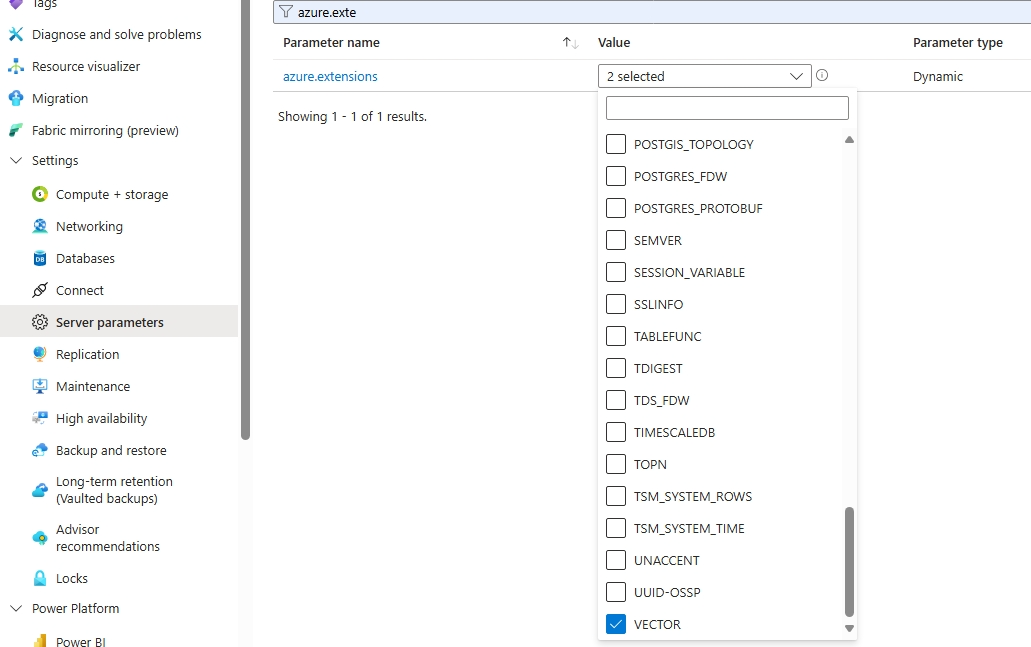 -->

#### Create a table and store vectors (using semantic kernel's vector store connector)

Let's first populate the vector table (it creates the index at the same time. HNSW is the only supported index for now. ETA for adding DiskANN support is by end of summer 2025.)

In [10]:
from semantic_kernel.connectors.memory.postgres import PostgresMemoryStore
from semantic_kernel.memory.memory_record import MemoryRecord
# connect to Azure postgres database
conn_uri = get_connection_uri()
conn = psycopg2.connect(conn_uri)
cur = conn.cursor()

# create an instance of PostgresMemoryStore
pg_store = PostgresMemoryStore(
    connection_string=conn_uri,
    default_dimensionality= 1536
)


# create a table for storing product description vectors
res = await pg_store.create_collection(
    collection_name="product_desc_sk",
    dimension_num=1536)

# generate embeddings for product descriptions and store them in the product_desc_vec table
cur.execute("SELECT product_id, description FROM products")
for row in cur.fetchall():
    prod_id, desc = row
    embedding = (await embedding_service.generate_embeddings([desc]))[0]
    # change type of embedding to memory record
    memory_record = MemoryRecord(
        id=str(prod_id),           
        embedding=embedding, 
        text =  desc,    
        description="",
        additional_metadata="",
        is_reference=False,
        external_source_name=""

    )
    # upsert the memory record into the PostgresMemoryStore and also builds the index
    await pg_store.upsert(
        collection_name="product_desc_sk",
        record=memory_record
    )

conn.commit()
conn.close()


Connection uri was rertieved successfully.


##### Example of getting top N results using sk's memory store functionality:

In [11]:
from typing import List, Tuple
from semantic_kernel.functions import kernel_function
from src.get_conn import get_connection_uri
import numpy as np
from semantic_kernel.connectors.memory.postgres import PostgresMemoryStore
from semantic_kernel.memory.memory_record import MemoryRecord


# we define it as a kernel function so that it can be used in the agent later
@kernel_function
async def get_similar_products_sk(embedding: np.ndarray , limit:int=3, collection_name="product_desc_sk") -> List[Tuple[MemoryRecord, float]]:
    """Returns the most similar products to the question."""
    # connect to Azure postgres database
    conn_uri = get_connection_uri()

    # create an instance of PostgresMemoryStore
    pg_store = PostgresMemoryStore(
        connection_string=conn_uri,
        default_dimensionality= 1536
    )

    
    res = await pg_store.get_nearest_matches(
        collection_name=collection_name,
        embedding=embedding,
        limit=limit
    )
    await pg_store.close()  # Close the connection to the PostgresMemoryStore
    return res

In [ ]:
example_embedding = (await embedding_service.generate_embeddings(["best sony smart tv"]))[0]
res= await get_similar_products_sk(example_embedding, limit=3)
for r in res:
    memory_record, score = r  # get_nearest_match returns a tuple (MemoryRecord, score)
    print("ID:", memory_record.id)
    print("Text:", memory_record.text)
    print("Score:", score)

### Putting it all together
Now let's tie everything together:
- PostgreSQL data plugin
- Skill to do semantic search based on product description content 
- Read and write history to cosmos db container per user/session

Since we can find top matches based on product description in two ways (1- diskANN and 2- HNSW index provided by SK vectore store), we define two different kernels and also two agents to test these separately.

In [13]:
from semantic_kernel import Kernel
def agent_for_sk_query(chat_plugin):
###################################### Agent with SK vector store for pg ######################################
    chat_kernel_sk = Kernel()
    chat_kernel_sk.add_plugin(
        plugin = chat_plugin,
        plugin_name = "Chat_Plugin"
    ) 
    chat_kernel_sk.add_function(
        function=get_similar_products_sk,
        function_name="get_similar_products_sk",
        plugin_name="query_plugin_sk"
    )

    support_agent_sk = ChatCompletionAgent(
        service=AzureChatCompletion(),
        name="SupportAgentSK",
        kernel=chat_kernel_sk,
        instructions="You are a support agent for Contoso. You can answer questions about products, and customers sales and returns. Use the 'Contoso_ChatPlugin' to access the company's database. Use 'query_plugin_sk' to get ids of most relevant products based on the question asked. The ids will be used to query the database for product information."
    )
    return support_agent_sk






##### Creating a fucntion to start the chat...

In [14]:
import random

async def start_chat(support_agent, chat_plugin):
    """Starts the chat with the support agent."""
    print("Welcome to Contoso Support Chat!")
    print("You can ask questions about products, sales, and returns.")
    print("Type 'exit' to end the chat.")
    customer_id = input("Please enter your customer ID: ")
    session_id = input("Please enter your session ID (or press Enter if this is a new chat/topic): ")

 
    # initiate chat history object
    hist = ChatHistoryInCosmosDB(
            session_id=session_id,
            customer_id=customer_id,
            container=container
        )
    res = await hist.read_history()

    if(not res):
        print("No previous chat history found for this customer. Starting a new chat session...")
        session_id = f"session_"+random.randint(1000, 9999).__str__()
        hist = ChatHistoryInCosmosDB(
            session_id=session_id,
            customer_id=customer_id,
            container=container)
        


    user_input = input("How can I help you today? (Type 'exit' to end the chat) > ")
    user_input = user_input + "for customer id: " + str(customer_id)
    while(True):
        
        response = await support_agent.get_response(messages=user_input,thread=hist)
        print(f"Support Agent: {response}")
        # hist = response.thread
        user_input = input("Customer >")
        if user_input.lower() == "exit":
            await hist.store_history()
            print("NOTE: If you would like to continue this chat in the future, use this session ID:", session_id)
            break

        
    chat_plugin.close_connection()
    return True

    

In [15]:
from src.get_conn import get_connection_uri
if __name__ == "__main__":
    conn_uri = get_connection_uri()
    chat_plugin = Contoso_ChatPlugin(db_uri=conn_uri)
    support_agent_sk = agent_for_sk_query(chat_plugin)
    await start_chat(support_agent_sk, chat_plugin)


Connection uri was rertieved successfully.
Connected to company's database successfully.
Welcome to Contoso Support Chat!
You can ask questions about products, sales, and returns.
Type 'exit' to end the chat.
No chat history for this customer and session_id was retrieved.
No previous chat history found for this customer. Starting a new chat session...
Support Agent: Yes, you have purchased an item. You bought one unit of "Tablet 0.2 new" for $650.00 on June 10, 2025. If you would like more details about this purchase or need assistance with returns or shipping, please let me know!
Support Agent: Your order for "Tablet 0.2 new" is currently still in transit and has not yet been delivered. If you need further assistance or want tracking details, please let me know!
Support Agent: Your name is Eve Black. If you need any other information or assistance, feel free to ask!
Messages stored in Cosmos DB with response: {'id': 'session_9401', 'customer_id': '7', 'messages': [{'ai_model_id': None

### **************** Using DiskANN ****************

While using built-in SK functionality to create and connect to vector store, index and retrieve results is preferred, as if now, the only indexing supported by SK vector connectors to retrieve top N results is HNSW: 
- https://learn.microsoft.com/en-us/semantic-kernel/concepts/vector-store-connectors/out-of-the-box-connectors/?pivots=programming-language-python
- https://learn.microsoft.com/en-us/semantic-kernel/concepts/vector-store-connectors/out-of-the-box-connectors/postgres-connector?pivots=programming-language-csharp

DiskANN is the newest and best index recently made available so if you want to use that, you would need to go with the first approach.

#### Ensure to enable PG_DISKANN extension for you Azure Database for PostgreSQL flexible server
<img src=".\imgs\pg_index.jpeg" alt="description" width="600" height="300"/>


In [19]:
import psycopg2

from src.get_conn import get_connection_uri

# connect to Azure postgres database
conn_uri = get_connection_uri()
conn = psycopg2.connect(conn_uri)
cur = conn.cursor()

# create product_desc table if it does not exist
cur.execute("""
    DROP TABLE IF EXISTS product_desc_ann CASCADE;
    CREATE TABLE product_desc_ann (
        vector_id SERIAL PRIMARY KEY,
        product_id INTEGER REFERENCES products(product_id),
        description TEXT NOT NULL,
        embedding vector(1536) NOT NULL
    );
""")
conn.commit()
cur.close()
cur = conn.cursor()

#generate embeddings for product descriptions and store them in the product_desc table
cur.execute("SELECT product_id, description FROM products")
for row in cur.fetchall():
    prod_id, desc = row
    # print(prod_id, desc)
    response = await embedding_service.generate_embeddings([desc])
    embedding = response[0]
    # print(f"Embedding for product {prod_id}: {embedding}")
    cur.execute(
        "INSERT INTO product_desc_ann (embedding, product_id, description) VALUES (%s,%s,%s)", (embedding.tolist(), prod_id, desc)
    )
print("All embeddings inserted into product_desc_ann table.")
conn.commit()
cur.close()
conn.close()

Connection uri was rertieved successfully.
All embeddings inserted into product_desc_ann table.


##### We first need to build the index (one time, or each time products table is updated)

In [20]:
query = """ CREATE INDEX product_desc_embedding_diskann_idx ON product_desc_ann 
USING diskann (embedding vector_cosine_ops)"""
conn = psycopg2.connect(conn_uri)
cur = conn.cursor()
cur.execute(query)
conn.commit()
conn.close()


##### now we can query to find top N matches using DiskANN

In [21]:
from pgvector.psycopg2 import register_vector

@kernel_function
async def get_similar_products_diskann(embedding: np.array, limit: int = 3) -> List[Tuple[int, List[float]]]:
    """Returns the most similar products to the question using diskann index."""

    example_embedding_l = str(embedding.tolist())
    
    conn_uri = get_connection_uri()
    conn = psycopg2.connect(conn_uri)
    register_vector(conn)
    cur = conn.cursor()
    
    cur.execute(
        """
        SELECT product_id, embedding, description
        FROM product_desc_ann
        ORDER BY embedding <-> %s
        LIMIT %s;
        """,
        (example_embedding_l, limit)
    )
    
    rows = cur.fetchall()
    cur.close()
    conn.close()
    
    return rows
example_embedding = (await embedding_service.generate_embeddings(["what is the best headphone I can get with active noise cancelling"]))[0]
rows = await get_similar_products_diskann(example_embedding, limit=3)

for row in rows:
    product_id, embedding, desc = row
    print(f"Product ID: {product_id} - Description: {desc}")


Connection uri was rertieved successfully.
Product ID: 12 - Description: High-quality wireless headphones with noise cancellation.
Product ID: 13 - Description: The Jabra Elite series of headphones, particularly the Jabra Elite 10, are designed to deliver a premium audio experience for both work and leisure. These true wireless earbuds feature a semi-open design with Jabras unique ComfortFit technology, developed from over 62,000 ear scans to ensure a secure, pressure-free fit for all-day wear. The Elite 10 is equipped with 10mm speakers that produce rich, immersive sound, enhanced by Spatial Sound with Dolby Head Tracking for a cinematic audio experience. One of the standout features is the Jabra Advanced Active Noise Cancellation (ANC), which automatically adapts to your environment and is twice as effective as their standard ANC. This makes them ideal for noisy settings like commutes or open offices. For calls, the Elite 10 uses a 6-microphone array with intelligent noise-reduction 

In [24]:
###################################### Agent with DiskANN ######################################
def agent_for_diskann_query(chat_plugin):
    chat_kernel_diskann = Kernel()
    chat_kernel_diskann.add_plugin(
        plugin = chat_plugin,
        plugin_name = "Chat_Plugin"
    ) 
    chat_kernel_diskann.add_function(
        function=get_similar_products_diskann,
        function_name="get_similar_products_diskann",
        plugin_name="query_plugin_diskann"
    )

    support_agent_diskann = ChatCompletionAgent(
        service=AzureChatCompletion(),
        name="SupportAgentDiskANN",
        kernel=chat_kernel_diskann,
        instructions="You are a support agent for Contoso. You can answer questions about products, customers, sales, and returns. Use the 'Contoso_ChatPlugin' to access the company's database. Use 'query_plugin_diskann' to get ids of most relevant products based on the question asked. The ids will be used to query the database for product information."
    )
    return support_agent_diskann


#### Now using DiskANN to do RAG for the chat...

In [ ]:
from src.get_conn import get_connection_uri
if __name__ == "__main__":
    conn_uri = get_connection_uri()
    chat_plugin = Contoso_ChatPlugin(db_uri=conn_uri)
    support_agent_ann = agent_for_diskann_query(chat_plugin)
    await start_chat(support_agent_ann, chat_plugin)
